In [1]:
import os
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model, preprocessing, split_forecasts_by_week, plot_coverage, print_forecasts_by_week,\
forecast_by_week, train_test_split,update_deepAR_parameters, hyperparameter_boxplots,\
generate_model_results_by_hp_dict, plot_model_results_by_hp, hp_color_plot
from PythonFiles.Configuration import Configuration
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from gluonts.mx import Trainer, DeepAREstimator
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.rolling_dataset import generate_rolling_dataset,StepStrategy
from gluonts.evaluation import make_evaluation_predictions, Evaluator
import ray
from ray.air import session
from ray import tune
import itertools
from gluonts.mx.distribution import NegativeBinomialOutput
config = Configuration()

In [2]:
df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Restored_Hyperparameter_results_26_04.csv", sep=',')

hp_search_space = {
    "num_cells": tune.grid_search([40, 80]),
    "num_layers": tune.grid_search([1, 5, 10]),
    "context_length":tune.grid_search([4, 52, 104]),
    "cell_type":tune.grid_search(["lstm", "gru"]),
    "epochs":tune.grid_search([20, 30, 40]),
    "use_feat_static_real":tune.grid_search([False, False]),
    "use_feat_dynamic_real":tune.grid_search([True, False]),
    "use_feat_static_cat":tune.grid_search([False,True]),
    "cardinality":tune.sample_from(lambda spec:[2]*411 if spec.config.use_feat_static_cat else None),
}

model_results_by_hp, overall_df = generate_model_results_by_hp_dict(df, hp_search_space)

There are combinations with fewer modelRuns!!
                           total_modelruns  independent_combinations
modelruns_per_combination                                           
8.0                                   2152                     269.0
7.0                                   1120                     160.0
6.0                                     18                       3.0


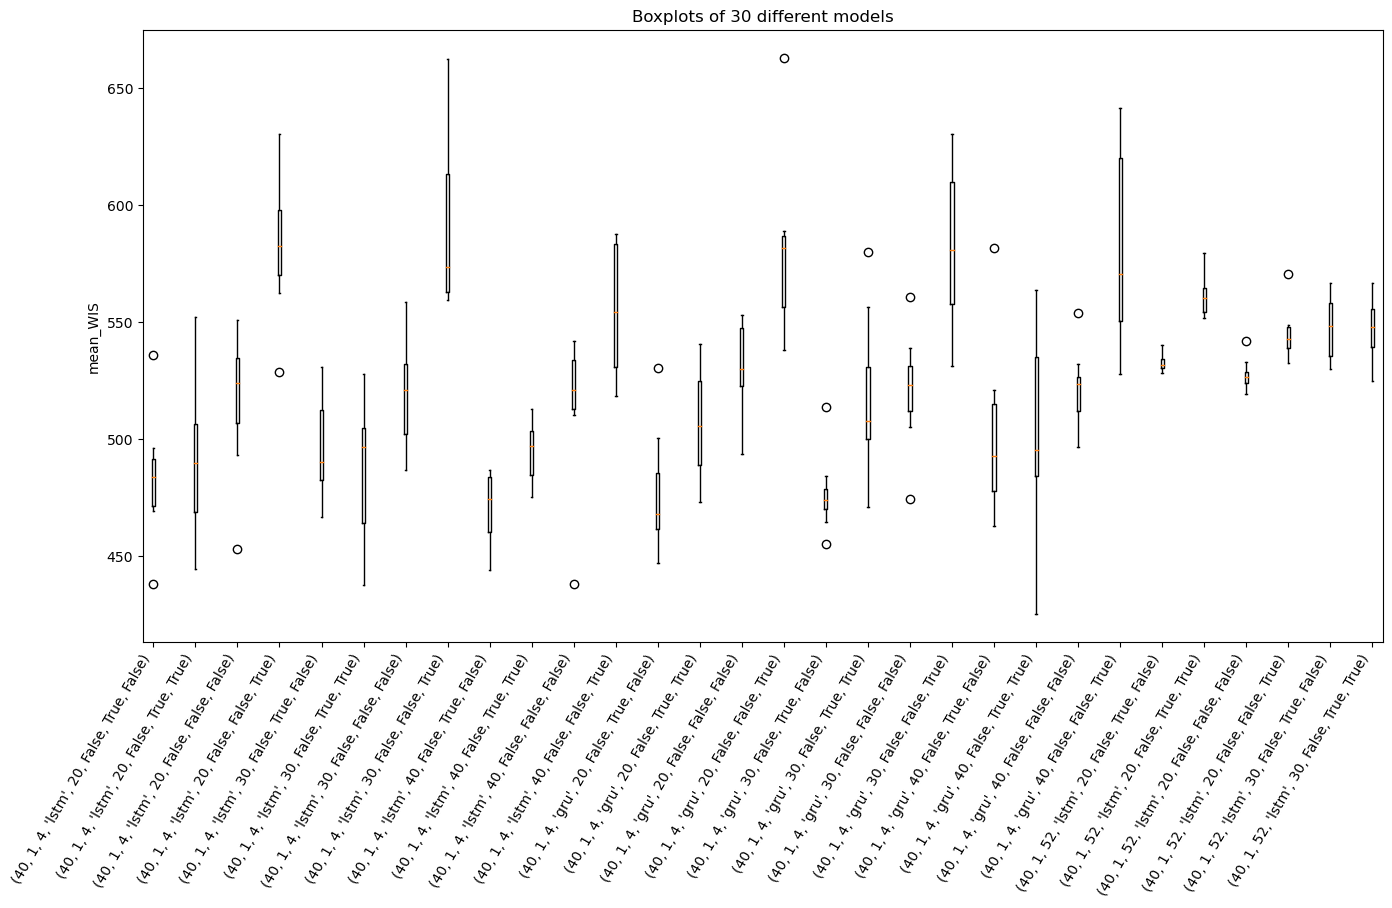

In [3]:
plot_model_results_by_hp(model_results_by_hp, number_of_plots=30, col="mean_WIS",figsize=(16, 9))

In [4]:
finished_modelRun_df = overall_df.loc[overall_df["shape"]==8,:]

In [5]:
added_cols = ["shape", "model_WIS_mean", "model_WIS_variance", "model_WIS_sd","model_time_mean", "model_time_variance",\
              "model_time_sd"]
display(overall_df.sort_values("model_WIS_mean")[added_cols+[col for col in df.columns if ("config" in col)&("cardinality" not in col)]].drop_duplicates().head(20))

,shape,model_WIS_mean,model_WIS_variance,model_WIS_sd,model_time_mean,model_time_variance,model_time_sd,config/cell_type,config/context_length,config/epochs,config/num_cells,config/num_layers,config/use_feat_dynamic_real,config/use_feat_static_cat,config/use_feat_static_real
2695,8.0,369.005892,326.513613,18.069688,4469.863914,1.628010e+06,1275.934773,gru,4,40,80,10,True,False,False
283,7.0,384.197802,440.422277,20.986240,5260.048269,1.662310e+07,4077.143983,gru,4,40,80,5,True,True,False
2908,7.0,388.954098,936.067647,30.595223,6679.818404,8.422264e+06,2902.113661,lstm,4,40,80,10,True,True,False
3105,8.0,394.685984,1059.291668,32.546761,3858.432448,2.046984e+06,1430.728410,gru,4,40,40,10,True,False,False
3086,8.0,400.001388,584.750535,24.181616,3918.452896,1.425805e+06,1194.070568,lstm,4,40,80,5,True,False,False
2902,7.0,405.803403,1896.638942,43.550418,6413.806462,1.649360e+07,4061.231593,lstm,4,30,80,10,True,True,False
2461,7.0,405.971861,2458.084994,49.579078,5256.062853,1.351359e+07,3676.084047,gru,4,40,40,10,True,True,False
2208,8.0,406.422974,1494.439051,38.657975,2997.031154,8.903518e+05,943.584526,lstm,4,40,40,5,True,False,False
2884,7.0,406.592609,956.202316,30.922521,5067.602754,1.452238e+07,3810.824028,lstm,4,30,40,10,True,True,False
49,8.0,409.852477,670.284012,25.889844,2753.331550,7.048177e+05,839.534200,gru,4,40,40,5,True,False,False


432
3290


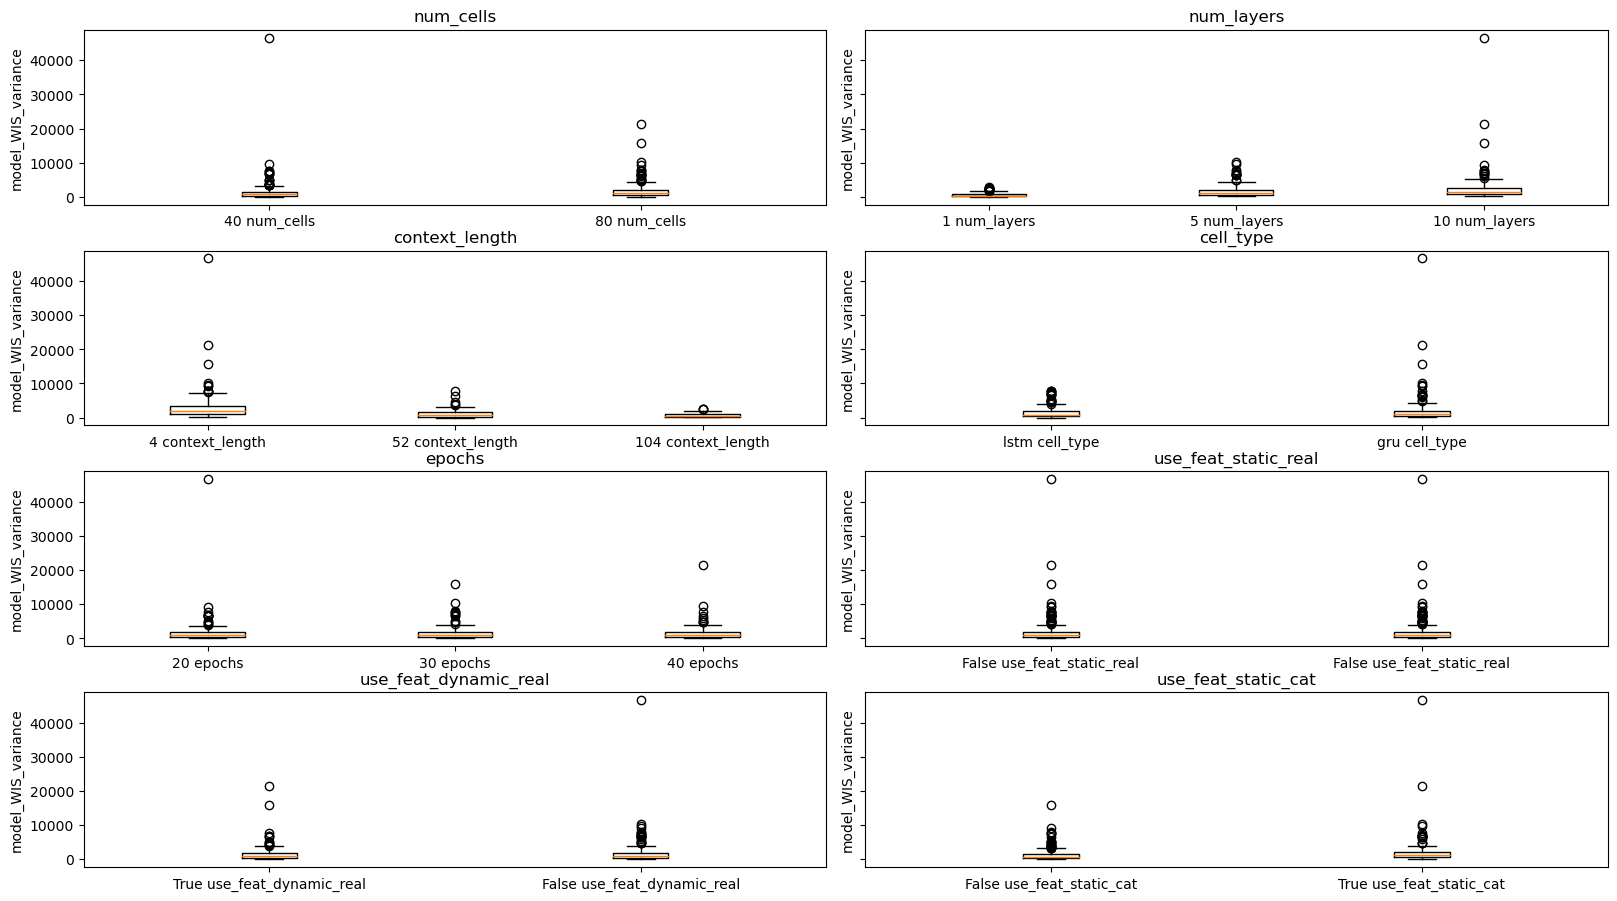

________________


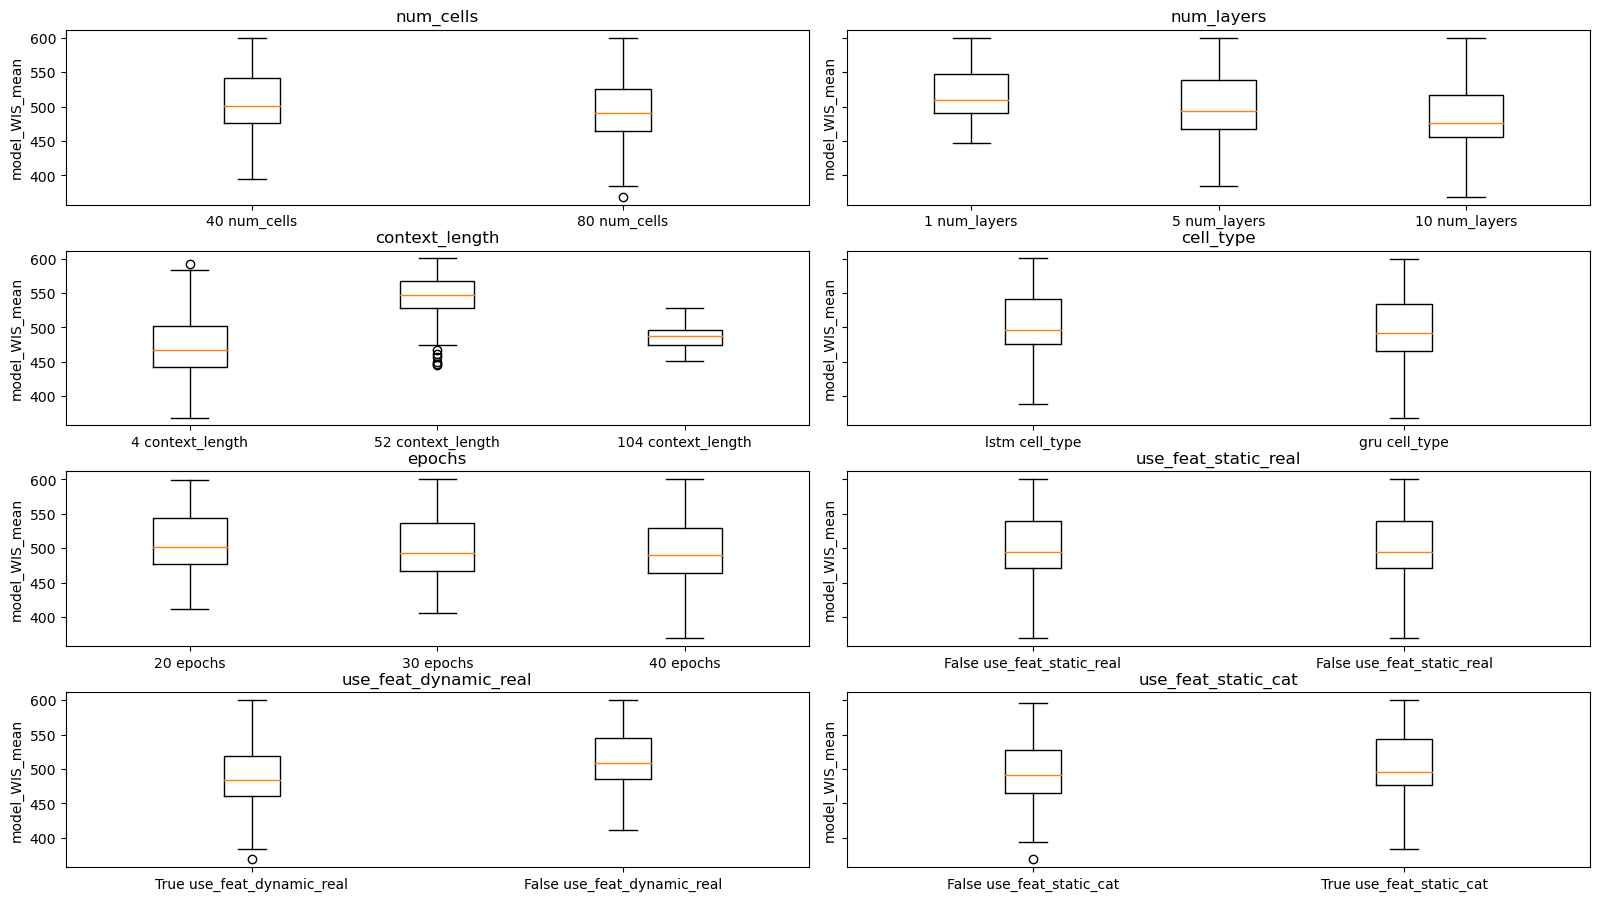

In [6]:
unique_df = overall_df[added_cols+[col for col in df.columns if ("config" in col)&("cardinality" not in col)]].drop_duplicates()
print(len(unique_df))
print(len(overall_df))
hyperparameter_boxplots(unique_df, hp_search_space, col="model_WIS_variance")
print("________________")
hyperparameter_boxplots(unique_df, hp_search_space, col="model_WIS_mean")

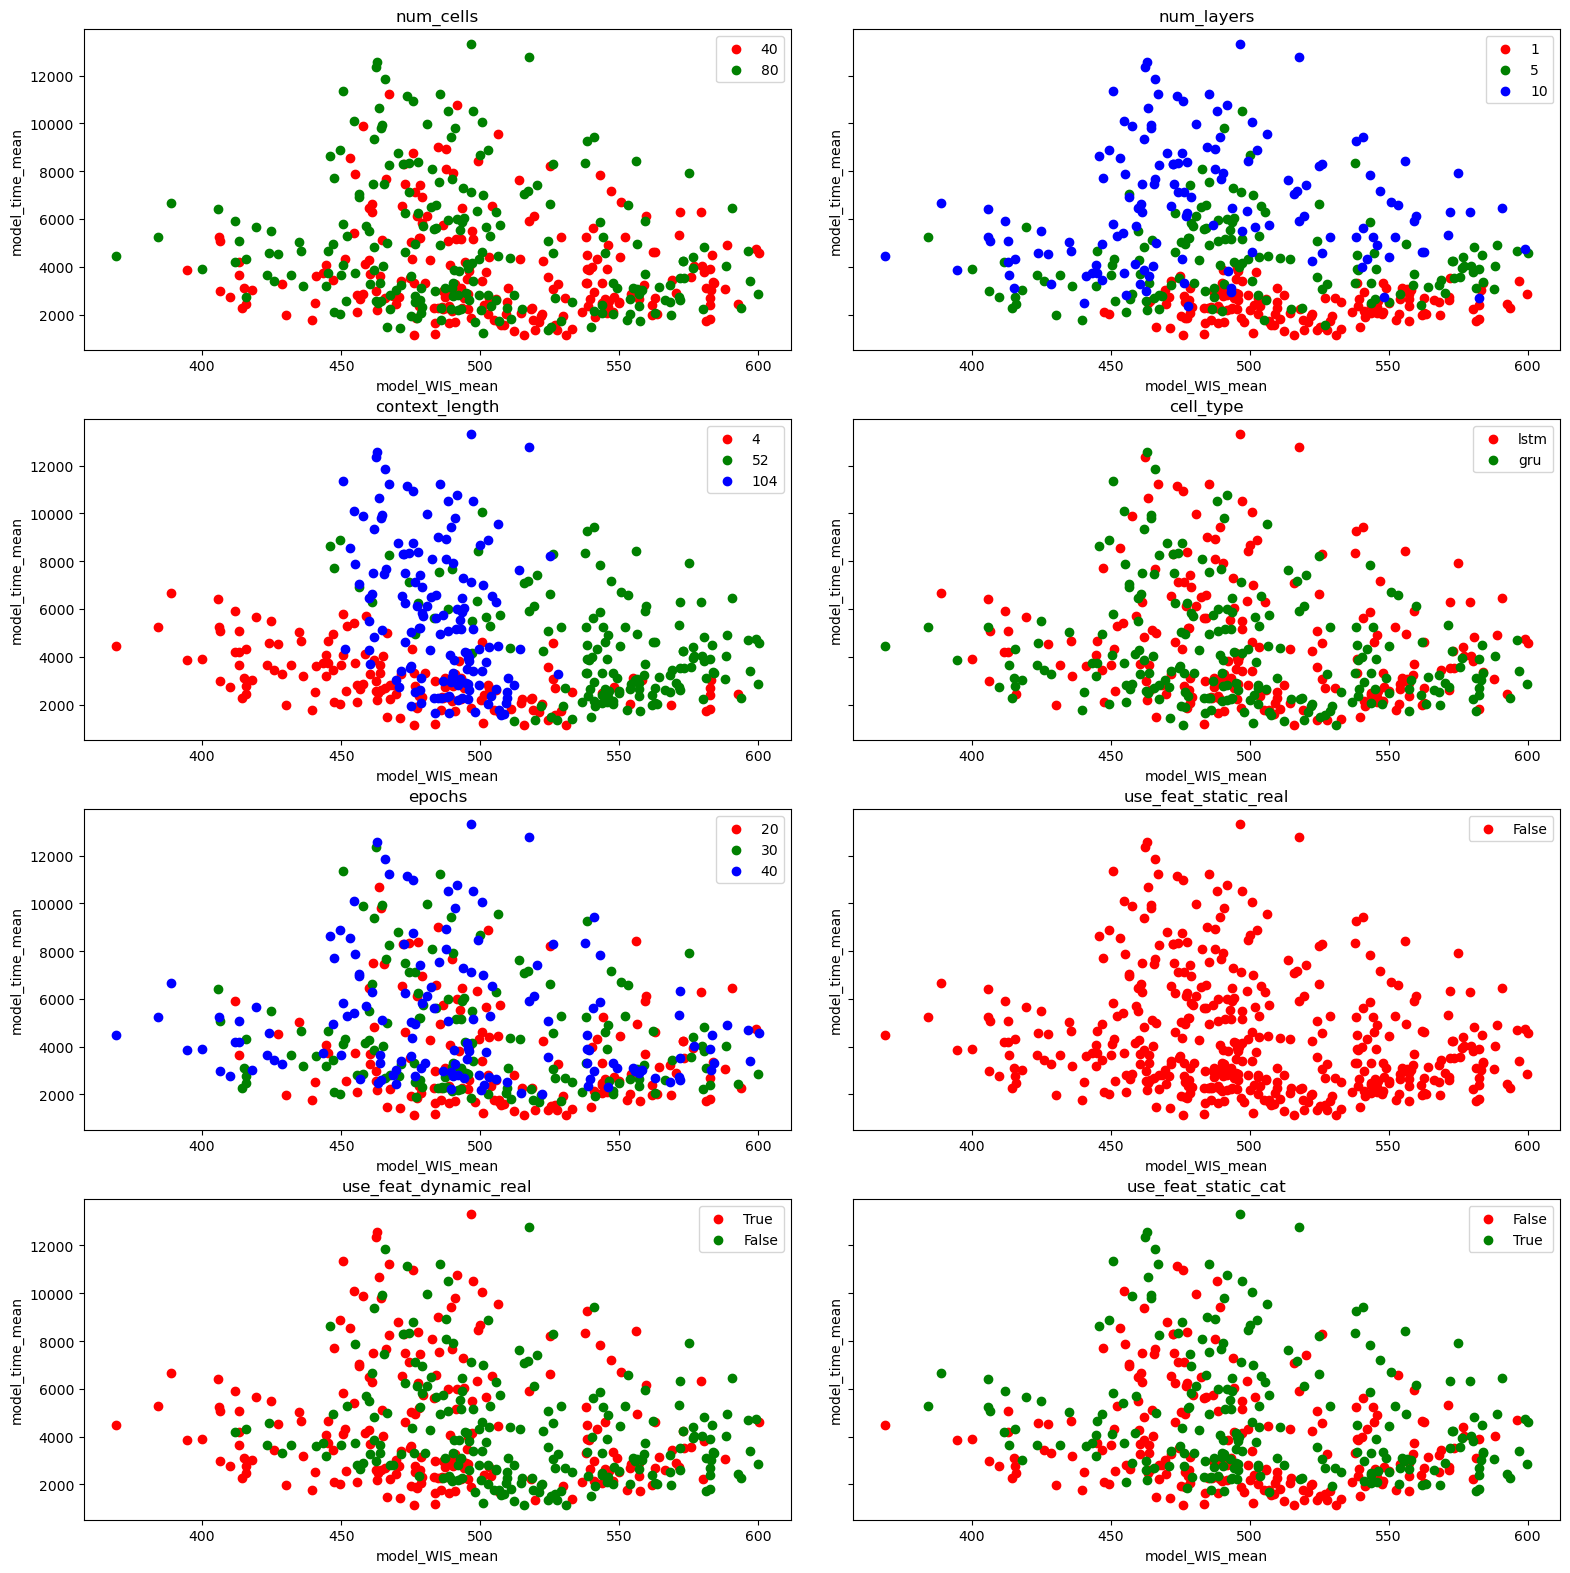

In [7]:
hp_color_plot(overall_df, hp_search_space)